## Import necessary libraries

In [1]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics

## Dataset preview

In [2]:
def image_count(dirname):
    count = 0
    for path in pathlib.Path(dirname).iterdir():
        if path.is_file():
            count += 1
    return count
train_NORMAL = image_count('/Users/pengjusun/Documents/Flatiron/Phase_4/Phase_4_Project/data/train/NORMAL')
train_PNEUMONIA = image_count('/Users/pengjusun/Documents/Flatiron/Phase_4/Phase_4_Project/data/train/PNEUMONIA')
val_NORMAL = image_count('/Users/pengjusun/Documents/Flatiron/Phase_4/Phase_4_Project/data/val/NORMAL')
val_PNEUMONIA = image_count('/Users/pengjusun/Documents/Flatiron/Phase_4/Phase_4_Project/data/val/PNEUMONIA')
test_NORMAL = image_count('/Users/pengjusun/Documents/Flatiron/Phase_4/Phase_4_Project/data/test/NORMAL')
test_PNEUMONIA = image_count('/Users/pengjusun/Documents/Flatiron/Phase_4/Phase_4_Project/data/test/PNEUMONIA')
NORMAL = train_NORMAL + val_NORMAL + test_NORMAL
PNEUMONIA = train_PNEUMONIA + val_PNEUMONIA + test_PNEUMONIA
NORMAL, PNEUMONIA

(1583, 4273)

In [3]:
train_image_count = train_NORMAL + train_PNEUMONIA
val_image_count = val_NORMAL + val_PNEUMONIA
test_image_count = test_NORMAL + test_PNEUMONIA
list_count = [train_image_count, val_image_count, test_image_count]

def train_val_test_per():
    for count in list_count:
        count_per = count/sum(list_count)*100
        print(count_per)
train_val_test_per()

89.07103825136612
0.273224043715847
10.655737704918032


**Comment**: Need rewrite above function adding names of each percentage of dataset split.

**Note**:
While common ratios for split used are: 70% train, 15% validation, 15% test, in this dataset, the validation set is only 0.27% percent of the entire data. Always make sure the train, validation, and test dataset is in the appropirate ratio and it contains sufficient data that allows the model to have prediction power. So, I will rearranged my dataset, resulting in this ratio: 70% train, 20% validation, and 10% test. 

In [4]:
data_1_NORMAL = image_count('/Users/pengjusun/Documents/Flatiron/Phase_4/Phase_4_Project/data_1/NORMAL')
data_1_PNEUMONIA = image_count('/Users/pengjusun/Documents/Flatiron/Phase_4/Phase_4_Project/data_1/PNEUMONIA')-1

In [5]:
data_1_NORMAL, data_1_PNEUMONIA

(1583, 4273)

## Basic EDA

In [6]:
# Show the image path
data_1_NORMAL_dir = 'data_1/NORMAL/'
data_1_PNEUMONIA_dir = 'data_1/PNEUMONIA/'
new_dir = 'split/'

In [7]:
print(len(os.listdir(data_1_NORMAL_dir)))
print(len(os.listdir(data_1_PNEUMONIA_dir)))#??????????????? one file is not endwith".jpeg"

1583
4274


In [8]:
# Create objects that stores all the relevant images
images_NORMAL = [file for file in os.listdir(data_1_NORMAL_dir) if file.endswith('.jpeg')]
images_PNEUMONIA = [file for file in os.listdir(data_1_PNEUMONIA_dir) if file.endswith('.jpeg')]

In [9]:
images_NORMAL[:5]

['NORMAL2-IM-0927-0001.jpeg',
 'NORMAL2-IM-1056-0001.jpeg',
 'IM-0427-0001.jpeg',
 'NORMAL2-IM-1260-0001.jpeg',
 'IM-0656-0001-0001.jpeg']

In [10]:
# See how many images there in NORMAL directory and PNEUMONIA directory
print('There are', len(images_NORMAL), 'NORMAL images')
print('There are', len(images_PNEUMONIA), 'PNEUMONIA images')

There are 1583 NORMAL images
There are 4273 PNEUMONIA images


Text(0, 0.5, 'Numer of Images')

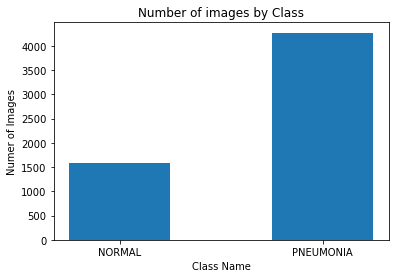

In [11]:
#Plot number of classes to identify imbalances
number_classes = {'NORMAL':1583,
                  'PNEUMONIA':4273}
plt.bar(number_classes.keys(), number_classes.values(), width = 0.5)
plt.title("Number of images by Class")
plt.xlabel("Class Name")
plt.ylabel("Numer of Images")

([<matplotlib.patches.Wedge at 0x1224cc3a0>,
 [Text(0.7266104793469584, 0.8258554421345079, ''),
  Text(-0.7926658931179512, -0.9009332838160221, '')],
 [Text(0.39633298873470457, 0.4504666048006406, '27.0%'),
  Text(-0.4623884376521382, -0.5255444155593462, '73.0%')])

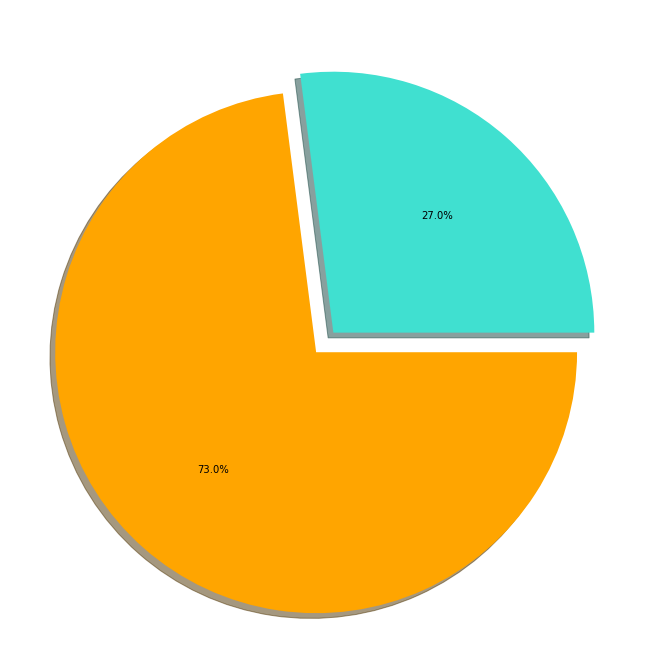

In [83]:
from  matplotlib import cm
figure =plt.figure(figsize=(12,12))
explode = [0, 0.1]
plt.pie(number_classes.values(),explode = explode,autopct = '%3.1f%%',shadow = True, colors = ('turquoise','orange'))

In [13]:
# Check on image size and take a loot at the some of the images
random.seed(42)
rand_normal = np.random.randint(0,len(os.listdir(data_1_NORMAL_dir )))
rand_pneumonia = np.random.randint(0,len(os.listdir(data_1_PNEUMONIA_dir )))
norm_pic = os.listdir(data_1_NORMAL_dir)[rand_normal]
pneu_pic = os.listdir(data_1_PNEUMONIA_dir)[rand_pneumonia]
print('normal picture title: ', norm_pic)
print('pneumonia picture tile:', pneu_pic)
norm_pic_address = data_1_NORMAL_dir + norm_pic
pneu_pic_address = data_1_PNEUMONIA_dir + pneu_pic

normal picture title:  IM-0245-0001.jpeg
pneumonia picture tile: person752_virus_1377.jpeg


In [14]:
def Image_show_size(address):
    im = Image.open(address)
    arr = np.array(im)
    return arr.shape

In [15]:
print('Random NORMAL image size: ', Image_show_size(norm_pic_address))
print('Random PNEUMONIA image size: ', Image_show_size(pneu_pic_address))

Random NORMAL image size:  (1480, 1724)
Random PNEUMONIA image size:  (610, 894)


In [16]:
def Image_show(address):
    im = Image.open(address) 
    fig = plt.figure(figsize = (10,6))
    image_plot = plt.imshow(im)
    plt.title(address)
#     if address in data_1_NORMAL_dir:
#         plt.title('NORMAL')
#     if address in data_1_PNEUMONIA_dir:
#         plt.title('PNEUMONIA')

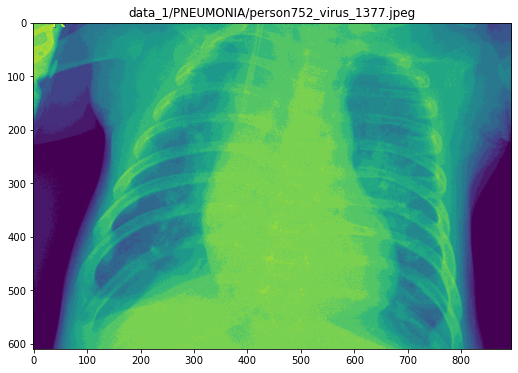

In [17]:
Image_show(pneu_pic_address)

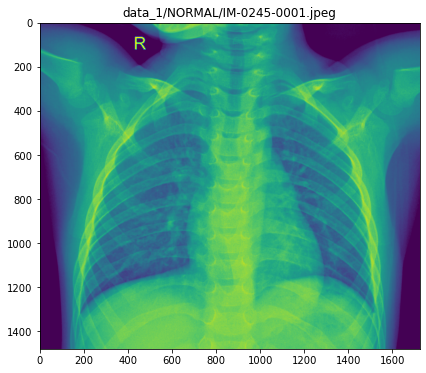

In [18]:
Image_show(norm_pic_address)

## Redo Train-Val-Test Split

In [19]:
# Creat folders and subfolders to get a hierarchical file structure
# Create a new folder 'split'
# os.mkdir(new_dir)

In [20]:
# Create a subfolder 'train' under the 'split'
train_folder = os.path.join(new_dir, 'train')
# Create subfolders 'train_NORMAL' and 'train_PNEUMONIA' under the 'train'
train_NORMAL = os.path.join(train_folder, 'NORMAL')
train_PNEUMONIA = os.path.join(train_folder, 'PNEUMONIA')
#___________________________________________________________________________
# Create a subfolder 'test' under the 'split'
test_folder = os.path.join(new_dir, 'test')
# Create subfolders 'test_NORMAL' and 'test_PNEUMONIA' under the 'test'
test_NORMAL = os.path.join(test_folder, 'NORMAL')
test_PNEUMONIA = os.path.join(test_folder, 'PNEUMONIA')
#___________________________________________________________________________
# Create a subfolder 'test' under the 'split'
val_folder = os.path.join(new_dir, 'validation')
# # Create subfolders 'val_NORMAL' and 'val_PNEUMONIA' under the 'test'
val_NORMAL = os.path.join(val_folder, 'NORMAL')
val_PNEUMONIA = os.path.join(val_folder, 'PNEUMONIA')

In [21]:
# Use all the path strings to make new directories
# os.mkdir(train_folder)
# os.mkdir(train_NORMAL)
# os.mkdir(train_PNEUMONIA)

# os.mkdir(test_folder)
# os.mkdir(test_NORMAL)
# os.mkdir(test_PNEUMONIA)

# os.mkdir(val_folder)
# os.mkdir(val_NORMAL)
# os.mkdir(val_PNEUMONIA)

In [22]:
# Use a 70%/20%/10% split for train/validation/test
print('Number of images to train')
print('# train_NORMAL: ', round(len(images_NORMAL)*0.7))
print('# train_PNEUMONIA: ', round(len(images_PNEUMONIA)*0.7))
print('________________________________________________')
print('Number of images to validation')
print('# val_NORMAL: ', round(len(images_NORMAL)*0.2))
print('# val_PNEUMONIA: ', round(len(images_PNEUMONIA)*0.2))
print('________________________________________________')
print('Number of images to test')
print('# test_NORMAL: ', round(len(images_NORMAL)*0.1))
print('# test_PNEUMONIA: ', round(len(images_PNEUMONIA)*0.1))

Number of images to train
# train_NORMAL:  1108
# train_PNEUMONIA:  2991
________________________________________________
Number of images to validation
# val_NORMAL:  317
# val_PNEUMONIA:  855
________________________________________________
Number of images to test
# test_NORMAL:  158
# test_PNEUMONIA:  427


In [23]:
# train NORMAL
# imgs = images_NORMAL[:1108]
# for img in imgs:
#     origin = os.path.join(data_1_NORMAL_dir, img)
#     destination = os.path.join(train_NORMAL, img)
#     shutil.copyfile(origin, destination)
# # validation NORMAL
# imgs = images_NORMAL[1108:1425]
# for img in imgs:
#     origin = os.path.join(data_1_NORMAL_dir, img)
#     destination = os.path.join(val_NORMAL, img)
#     shutil.copyfile(origin, destination)
# # test NORMAL
# imgs = images_NORMAL[1425:]
# for img in imgs:
#     origin = os.path.join(data_1_NORMAL_dir, img)
#     destination = os.path.join(test_NORMAL, img)
#     shutil.copyfile(origin, destination)

In [24]:
# train PNEUMONIA
# imgs = images_PNEUMONIA
# for img in imgs[:2991]:
#     origin = os.path.join(data_1_PNEUMONIA_dir, img)
#     destination = os.path.join(train_PNEUMONIA, img)
#     shutil.copyfile(origin, destination)
# # validation PNEUMONIA
# imgs = images_PNEUMONIA[2991:3846]
# for img in imgs:
#     origin = os.path.join(data_1_PNEUMONIA_dir, img)
#     destination = os.path.join(val_PNEUMONIA, img)
#     shutil.copyfile(origin, destination)
# # test PNEUMONIA
# imgs = images_PNEUMONIA[3846:]
# for img in imgs:
#     origin = os.path.join(data_1_PNEUMONIA_dir, img)
#     destination = os.path.join(test_PNEUMONIA, img)
#     shutil.copyfile(origin, destination)

In [25]:
print('There are', len(os.listdir(train_NORMAL)), 'NORMAL images in the training set')
print('There are', len(os.listdir(val_NORMAL)), 'NORMAL images in the validation set')
print('There are', len(os.listdir(test_NORMAL)), 'NORMAL images in the test set')

There are 1108 NORMAL images in the training set
There are 317 NORMAL images in the validation set
There are 158 NORMAL images in the test set


In [26]:
print('There are', len(os.listdir(train_PNEUMONIA))-1, 'PNEUMONIA images in the training set')
print('There are', len(os.listdir(val_PNEUMONIA))-1, 'PNEUMONIA images in the validation set')
print('There are', len(os.listdir(test_PNEUMONIA))-1, 'PNEUMONIA images in the test set')

There are 2991 PNEUMONIA images in the training set
There are 855 PNEUMONIA images in the validation set
There are 427 PNEUMONIA images in the test set


## EDA for New Training data

In [27]:
train_dir = 'split/train'
train_NORMAL_dir = 'split/train/NORMAL/'
train_PNEUMONIA_dir = 'split/train/PNEUMONIA/'

validation_dir = 'split/validation'
validation_NORMAL_dir = 'split/validation/NORMAL/'
validation_PNEUMONIA_dir = 'split/validation/PNEUMONIA/'

test_dir = 'split/test'
test_NORMAL_dir = 'split/test/NORMAL/'
test_PNEUMONIA_dir = 'split/test/PNEUMONIA/'

In [28]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpeg')])
    return num

In [29]:
train_NORMAL_num = num_files_in_direcotry(train_NORMAL_dir)
train_PNEUMONIA_num = num_files_in_direcotry(train_PNEUMONIA_dir)
train_SUM_num = train_NORMAL_num + train_PNEUMONIA_num

print("[Train] Number of NORMAL Images: ", train_NORMAL_num)
print("[Train] Number of PNEUMONIA Images: ", train_PNEUMONIA_num)
print("[Train] Number of TOTAL Images: ", train_SUM_num)

[Train] Number of NORMAL Images:  1108
[Train] Number of PNEUMONIA Images:  2991
[Train] Number of TOTAL Images:  4099


In [30]:
val_NORMAL_num = num_files_in_direcotry(validation_NORMAL_dir)
val_PNEUMONIA_num = num_files_in_direcotry(validation_PNEUMONIA_dir)
val_SUM_num = val_NORMAL_num + val_PNEUMONIA_num

print("[Validation] Number of NORMAL Images: ", val_NORMAL_num)
print("[Validation] Number of PNEUMONIA Images: ", val_PNEUMONIA_num)
print("[Validation] Number of TOTAL Images: ", val_SUM_num)

[Validation] Number of NORMAL Images:  317
[Validation] Number of PNEUMONIA Images:  855
[Validation] Number of TOTAL Images:  1172


In [31]:
test_NORMAL_num = num_files_in_direcotry(test_NORMAL_dir)
test_PNEUMONIA_num = num_files_in_direcotry(test_PNEUMONIA_dir)
test_SUM_num = test_NORMAL_num + test_PNEUMONIA_num

print("[test] Number of NORMAL Images: ", test_NORMAL_num)
print("[test] Number of PNEUMONIA Images: ", test_PNEUMONIA_num)
print("[test] Number of TOTAL Images: ", test_SUM_num)

[test] Number of NORMAL Images:  158
[test] Number of PNEUMONIA Images:  427
[test] Number of TOTAL Images:  585


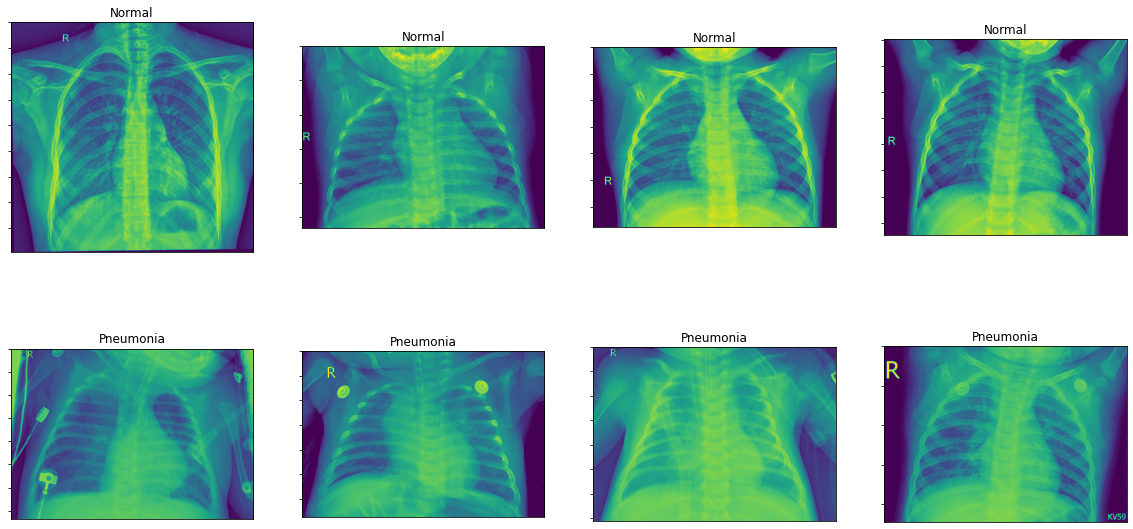

In [32]:
# Plot NORMAL and PNEUMONIA in new training dataset
plt.figure(figsize = (20,10))
num_imgs_1 = 4
for index in range(num_imgs_1):
    train_norm_pic_name = os.listdir(train_NORMAL_dir)[index]
    train_norm_pic_address = train_NORMAL_dir + train_norm_pic_name
#    fig, ax_list = plt.sunplots(nrows = 2, ncols =4)
    plt.subplot(2, num_imgs_1, index + 1)
    plt.imshow(Image.open(train_norm_pic_address))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)
    plt.title('Normal')

    train_pneu_pic_name = os.listdir(train_PNEUMONIA_dir)[index]
    train_pneu_pic_address = train_PNEUMONIA_dir + train_pneu_pic_name

    plt.subplot(2, num_imgs_1, index + num_imgs_1 + 1)
    plt.imshow(Image.open(train_pneu_pic_address))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)
    plt.title('Pneumonia')

In [33]:
# Check New traning dataset images sizes
num_imgs_2 = 15
for index in range(num_imgs_2):
    train_norm_pic_name = os.listdir(train_NORMAL_dir)[index]
    train_norm_pic_address = train_NORMAL_dir + train_norm_pic_name
    train_norm_image = Image.open(train_norm_pic_address)
    train_norm_width, train_norm_height = train_norm_image.size
    print('train_NORMAL_image', index + 1, ":" , train_norm_width, 'x', train_norm_height)

    train_pneu_pic_name = os.listdir(train_PNEUMONIA_dir)[index]
    train_pneu_pic_address = train_PNEUMONIA_dir + train_pneu_pic_name
    train_pneu_image = Image.open(train_pneu_pic_address)
    train_pneu_width, train_pneu_height = train_pneu_image.size
    print('train_PNEUMONIA_image', index + 1, ":" , train_pneu_width, 'x', train_pneu_height)
    print('\n')

# All images are in different sizes

train_NORMAL_image 1 : 2359 x 2234
train_PNEUMONIA_image 1 : 1048 x 736


train_NORMAL_image 2 : 1422 x 1067
train_PNEUMONIA_image 2 : 984 x 672


train_NORMAL_image 3 : 1828 x 1357
train_PNEUMONIA_image 3 : 992 x 712


train_NORMAL_image 4 : 1854 x 1495
train_PNEUMONIA_image 4 : 1224 x 888


train_NORMAL_image 5 : 2194 x 1966
train_PNEUMONIA_image 5 : 864 x 480


train_NORMAL_image 6 : 2172 x 1963
train_PNEUMONIA_image 6 : 944 x 584


train_NORMAL_image 7 : 1902 x 1665
train_PNEUMONIA_image 7 : 1816 x 1110


train_NORMAL_image 8 : 1284 x 1086
train_PNEUMONIA_image 8 : 1408 x 1024


train_NORMAL_image 9 : 1188 x 885
train_PNEUMONIA_image 9 : 1200 x 552


train_NORMAL_image 10 : 1432 x 1184
train_PNEUMONIA_image 10 : 1336 x 1256


train_NORMAL_image 11 : 1442 x 1152
train_PNEUMONIA_image 11 : 1400 x 1040


train_NORMAL_image 12 : 1410 x 1106
train_PNEUMONIA_image 12 : 1016 x 608


train_NORMAL_image 13 : 2373 x 2663
train_PNEUMONIA_image 13 : 1360 x 936


train_NORMAL_image 14 : 1949 x 